<a href="https://colab.research.google.com/github/luan1199/colab_projects/blob/master/mobile_net_transferlearning_XAI_WITH_LIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.


from __future__ import absolute_import, division, print_function

import os
import tensorflow as tf
from tensorflow import keras
print("tensorflow version:", tf.__version__)

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.python.keras.backend import set_session
sess = tf.Session()

set_session(sess)

tensorflow version: 1.15.0-rc3


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
base_dir, _ = os.path.splitext("/content/drive/My Drive/separated_imgs")
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "val")

print("TRAIN BASE")
c0_dir_train = os.path.join(train_dir, "c0")
print("total c0 images:", len(os.listdir(c0_dir_train)))

c1_dir_train = os.path.join(train_dir, "c1")
print("total c1 images:", len(os.listdir(c1_dir_train)))

c2_dir_train = os.path.join(train_dir, "c2")
print("total c2 images:", len(os.listdir(c2_dir_train)))

c3_dir_train = os.path.join(train_dir, "c3")
print("total c3 images:", len(os.listdir(c3_dir_train)))

c4_dir_train = os.path.join(train_dir, "c4")
print("total c4 images:", len(os.listdir(c4_dir_train)))

print("-------------------------------")

print("VAL BASE")
c0_dir_val = os.path.join(validation_dir, "c0")
print("total c0 images:", len(os.listdir(c0_dir_val)))

c1_dir_val = os.path.join(validation_dir, "c1")
print("total c1 images:", len(os.listdir(c1_dir_val)))

c2_dir_val = os.path.join(validation_dir, "c2")
print("total c2 images:", len(os.listdir(c2_dir_val)))

c3_dir_val = os.path.join(validation_dir, "c3")
print("total c3 images:", len(os.listdir(c3_dir_val)))

c4_dir_val = os.path.join(validation_dir, "c4")
print("total c4 images:", len(os.listdir(c4_dir_val)))

TRAIN BASE
total c0 images: 1796
total c1 images: 1621
total c2 images: 1666
total c3 images: 1733
total c4 images: 1705
-------------------------------
VAL BASE
total c0 images: 693
total c1 images: 646
total c2 images: 651
total c3 images: 613
total c4 images: 621


In [0]:
image_size = 224
batch_size = 32

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)# normalização e data augmentation

val_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(image_size, image_size),
                                                   batch_size=batch_size,
                                                   class_mode="categorical",shuffle=False)

val_generator = val_datagen.flow_from_directory(validation_dir,
                                               target_size=(image_size, image_size),
                                               batch_size=batch_size,
                                               class_mode="categorical",shuffle=False)



Found 8521 images belonging to 5 classes.
Found 3224 images belonging to 5 classes.


In [0]:
img_shape = (image_size, image_size, 3)

mobilenet = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                              include_top=False,
                                              weights='imagenet')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
9412608/9406464 [==============================] - 1s 0us/step


In [0]:
mobilenet.trainable = False#impede que os pessos deem reset.

In [0]:
mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint
model = tf.keras.Sequential([mobilenet,
                            keras.layers.MaxPool2D(),
                             keras.layers.Flatten(),
                            keras.layers.Dense(5, activation = 'softmax')])

sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=sgd,
             loss="categorical_crossentropy",
             metrics=["accuracy"])

filepath="/content/drive/My Drive/checkpoint_mobilnetv2/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 57605     
Total params: 2,315,589
Trainable params: 57,605
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
len(model.trainable_variables)

2

In [0]:
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

In [0]:
model.load_weights("/content/drive/My Drive/checkpoint_mobilnetv2/weights-improvement-04-0.41.hdf5")

In [0]:

steps_per_epoch = train_generator.n
validation_steps = val_generator.n

import time
since = time.time()

history = model.fit_generator(train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=50,
                             workers=4,
                             validation_data=val_generator,
                             validation_steps=validation_steps,
                             callbacks=callbacks_list)


time_elapsed = time.time() - since

print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


In [0]:
#@title Default title text
model.load_weights("/content/drive/My Drive/checkpoint_mobilnetv2/weights-improvement-04-0.41.hdf5")
sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=sgd,
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [0]:
model.evaluate(val_generator)

In [0]:
y_true = val_generator.classes; y_pred = model.predict_generator(val_generator,verbose=1)

101/101 [==============================] - 965s 10s/step


In [0]:
y_pred_2 = y_pred.argmax(axis=1)
y_pred_2

import sklearn.metrics as sk

cm = sk.classification_report(y_true,y_pred_2)
print(cm)

In [0]:
index = 3224
x = y_true == y_pred_2
x

In [0]:
x.sum() / index 

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [0]:
print_confusion_matrix(sk.confusion_matrix(y_true, y_pred_2),["normal_driving","texting - right","phone - right","texting - left","phone - left"])

## XAI TIME

In [0]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
!pip install lime
from lime import lime_image
import skimage
from skimage.segmentation import mark_boundaries

In [0]:
def transform_img_fn(path_list):
    out = []

    for img_path in path_list:
      img = image.load_img(img_path, target_size=(224, 224, 3))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
      out.append(x)
    return np.vstack(out)


def explain_img(path, file_name):
  imgs = transform_img_fn([os.path.join(path,file_name)])
  preds = model.predict(imgs)

  
  explainer = lime_image.LimeImageExplainer()
  %%time
  explanation = explainer.explain_instance(imgs[0],model.predict, top_labels=5, hide_color=0, num_samples=5 )
  
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
  plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
  plt.imsave(file_name[:8]+'jpg',mark_boundaries(temp / 2 + 0.5, mask))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.95447e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.95447e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.95447e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.95447e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.95447e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.21945e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.21945e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.21945e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.21945e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.21945e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.89982e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.89982e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.89982e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.89982e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.89982e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.08435e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.08435e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.08435e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.08435e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.08435e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.60435e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.60435e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.60435e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.60435e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.60435e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.67039e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.67039e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.67039e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.67039e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.67039e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.40106e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.40106e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.40106e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.40106e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.40106e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.39195e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.39195e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.39195e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.39195e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.39195e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.40602e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.40602e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.40602e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.40602e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.40602e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.82788e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.82788e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.82788e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.82788e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.82788e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.11 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.23554e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.23554e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.23554e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.23554e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.23554e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.47575e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.47575e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.47575e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.47575e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.47575e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.84893e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.84893e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.84893e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.84893e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.84893e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.72648e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.72648e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.72648e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.72648e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.72648e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.5979e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.5979e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.5979e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.5979e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.5979e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.39883e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.39883e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.39883e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.39883e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.39883e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 26.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.98516e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.98516e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.98516e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.98516e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.98516e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.46556e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.46556e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.46556e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.46556e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.46556e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.13463e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.13463e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.13463e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.13463e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.13463e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.97965e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.97965e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.97965e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.97965e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.97965e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.83599e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.83599e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.83599e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.83599e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.83599e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.60661e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.60661e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.60661e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.60661e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.60661e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.44311e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.44311e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.44311e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.44311e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.44311e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.60922e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.60922e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.60922e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.60922e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.60922e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.06879e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.06879e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.06879e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.06879e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.06879e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.77424e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.77424e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.77424e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.77424e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.77424e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.55083e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.55083e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.55083e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.55083e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.55083e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.85647e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.85647e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.85647e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.85647e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.85647e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.99368e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.99368e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.99368e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.99368e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.99368e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.63 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.68026e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.68026e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.68026e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.68026e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.68026e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.40964e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.40964e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.40964e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.40964e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.40964e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.24447e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.24447e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.24447e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.24447e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.24447e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.43327e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.43327e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.43327e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.43327e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.43327e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.42135e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.42135e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.42135e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.42135e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.42135e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.93624e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.93624e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.93624e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.93624e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.93624e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.66972e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.66972e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.66972e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.66972e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.66972e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.62903e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.62903e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.62903e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.62903e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.62903e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.04773e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.04773e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.04773e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.04773e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.04773e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 0 ns, sys: 5 µs, total: 5 µs
Wall time: 9.06 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.34 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.72256e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.72256e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.72256e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.72256e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.72256e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.39115e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.39115e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.39115e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.39115e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.39115e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.70676e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.70676e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.70676e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.70676e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.70676e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.33146e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.33146e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.33146e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.33146e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.33146e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.55828e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.55828e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.55828e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.55828e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.55828e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.93282e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.93282e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.93282e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.93282e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.93282e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94824e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94824e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94824e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94824e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94824e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.7655e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.7655e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.7655e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.7655e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.7655e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.03716e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.03716e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.03716e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.03716e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.03716e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.83705e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.83705e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.83705e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.83705e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.83705e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.22706e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.22706e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.22706e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.22706e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.22706e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.4785e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.4785e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.4785e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.4785e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.4785e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.10378e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.10378e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.10378e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.10378e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.10378e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.61841e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.61841e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.61841e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.61841e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.61841e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.46495e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.46495e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.46495e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.46495e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.46495e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.74705e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.74705e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.74705e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.74705e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.74705e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.17176e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.17176e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.17176e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.17176e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.17176e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.71787e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.71787e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.71787e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.71787e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.71787e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.83141e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.83141e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.83141e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.83141e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.83141e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.64687e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.64687e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.64687e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.64687e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.64687e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.29078e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.29078e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.29078e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.29078e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.29078e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.66214e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.66214e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.66214e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.66214e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.66214e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.63082e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.63082e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.63082e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.63082e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.63082e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.0795e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.0795e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.0795e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.0795e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.0795e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.19222e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.19222e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.19222e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.19222e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.19222e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.24732e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.24732e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.24732e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.24732e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.24732e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.69838e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.69838e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.69838e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.69838e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.69838e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.47671e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.47671e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.47671e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.47671e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.47671e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.17142e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.17142e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.17142e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.17142e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.17142e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.24458e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.24458e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.24458e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.24458e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.24458e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.26309e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.26309e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.26309e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.26309e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.26309e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94172e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94172e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94172e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94172e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94172e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.7 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.5243e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.5243e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.5243e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.5243e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.5243e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.37241e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.37241e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.37241e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.37241e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.37241e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.65324e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.65324e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.65324e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.65324e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.65324e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.39469e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.39469e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.39469e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.39469e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.39469e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.21517e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.21517e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.21517e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.21517e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.21517e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.69603e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.69603e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.69603e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.69603e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.69603e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.33385e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.33385e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.33385e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.33385e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.33385e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.75077e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.75077e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.75077e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.75077e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.75077e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.11534e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.11534e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.11534e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.11534e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.11534e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.57411e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.57411e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.57411e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.57411e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.57411e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.91488e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.91488e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.91488e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.91488e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.91488e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.17151e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.17151e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.17151e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.17151e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.17151e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.68553e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.68553e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.68553e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.68553e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.68553e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.25691e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.25691e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.25691e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.25691e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.25691e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.08624e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.08624e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.08624e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.08624e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.08624e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.53153e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.53153e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.53153e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.53153e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.53153e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.53245e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.53245e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.53245e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.53245e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.53245e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.28117e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.28117e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.28117e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.28117e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.28117e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.54249e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.54249e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.54249e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.54249e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.54249e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.97796e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.97796e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.97796e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.97796e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.97796e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.39472e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.39472e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.39472e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.39472e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.39472e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.14589e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.14589e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.14589e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.14589e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.14589e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.36524e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.36524e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.36524e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.36524e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.36524e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.24842e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.24842e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.24842e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.24842e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.24842e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.52518e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.52518e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.52518e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.52518e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.52518e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.31994e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.31994e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.31994e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.31994e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.31994e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.47934e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.47934e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.47934e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.47934e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.47934e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.73516e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.73516e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.73516e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.73516e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.73516e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.04609e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.04609e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.04609e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.04609e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.04609e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.99619e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.99619e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.99619e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.99619e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.99619e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.55339e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.55339e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.55339e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.55339e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.55339e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.51199e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.51199e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.51199e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.51199e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.51199e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.07722e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.07722e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.07722e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.07722e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.07722e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.04356e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.04356e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.04356e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.04356e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.04356e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.50418e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.50418e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.50418e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.50418e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.50418e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.39724e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.39724e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.39724e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.39724e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.39724e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.24192e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.24192e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.24192e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.24192e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.24192e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.35808e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.35808e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.35808e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.35808e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.35808e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.00307e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.00307e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.00307e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.00307e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.00307e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.23149e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.23149e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.23149e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.23149e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.23149e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.0686e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.0686e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.0686e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.0686e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.0686e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.06384e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.06384e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.06384e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.06384e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.06384e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.10824e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.10824e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.10824e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.10824e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.10824e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.70974e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.70974e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.70974e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.70974e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.70974e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.78601e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.78601e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.78601e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.78601e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.78601e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.19103e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.19103e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.19103e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.19103e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.19103e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.10398e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.10398e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.10398e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.10398e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.10398e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.01055e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.01055e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.01055e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.01055e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.01055e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.60947e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.60947e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.60947e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.60947e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.60947e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.10867e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.10867e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.10867e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.10867e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.10867e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.14328e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.14328e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.14328e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.14328e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.14328e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.41692e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.41692e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.41692e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.41692e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.41692e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.24341e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.24341e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.24341e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.24341e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.24341e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.09381e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.09381e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.09381e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.09381e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.09381e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.27291e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.27291e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.27291e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.27291e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.27291e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.26599e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.26599e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.26599e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.26599e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.26599e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.45819e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.45819e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.45819e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.45819e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.45819e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.11998e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.11998e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.11998e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.11998e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.11998e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.84314e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.84314e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.84314e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.84314e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.84314e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.19064e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.19064e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.19064e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.19064e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.19064e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.64504e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.64504e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.64504e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.64504e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.64504e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.68986e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.68986e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.68986e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.68986e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.68986e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.13007e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.13007e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.13007e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.13007e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.13007e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.19472e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.19472e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.19472e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.19472e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.19472e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 15 µs, sys: 1 µs, total: 16 µs
Wall time: 19.1 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.16366e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.16366e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.16366e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.16366e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.16366e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.3318e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.3318e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.3318e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.3318e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.3318e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.90273e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.90273e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.90273e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.90273e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.90273e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.48092e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.48092e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.48092e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.48092e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.48092e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 24.1 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.83499e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.83499e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.83499e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.83499e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.83499e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.81028e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.81028e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.81028e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.81028e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.81028e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.5923e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.5923e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.5923e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.5923e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.5923e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.64075e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.64075e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.64075e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.64075e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.64075e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.11721e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.11721e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.11721e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.11721e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.11721e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.39897e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.39897e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.39897e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.39897e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.39897e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 7.87 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.21801e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.21801e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.21801e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.21801e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.21801e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.12024e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.12024e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.12024e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.12024e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.12024e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.38156e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.38156e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.38156e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.38156e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.38156e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.39699e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.39699e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.39699e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.39699e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.39699e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.41247e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.41247e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.41247e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.41247e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.41247e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 12.4 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.9303e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.9303e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.9303e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.9303e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.9303e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.82921e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.82921e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.82921e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.82921e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.82921e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.6658e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.6658e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.6658e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.6658e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.6658e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.14482e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.14482e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.14482e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.14482e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.14482e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.7016e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.7016e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.7016e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.7016e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.7016e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.00094e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.00094e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.00094e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.00094e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.00094e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.49883e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.49883e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.49883e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.49883e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.49883e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.06525e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.06525e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.06525e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.06525e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.06525e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.93876e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.93876e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.93876e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.93876e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.93876e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.32341e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.32341e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.32341e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.32341e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.32341e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.63 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.53102e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.53102e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.53102e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.53102e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.53102e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.97486e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.97486e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.97486e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.97486e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.97486e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.2513e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.2513e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.2513e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.2513e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.2513e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.03717e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.03717e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.03717e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.03717e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.03717e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.32142e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.32142e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.32142e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.32142e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.32142e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.1786e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.1786e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.1786e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.1786e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.1786e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.74696e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.74696e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.74696e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.74696e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.74696e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.5331e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.5331e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.5331e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.5331e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.5331e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.29065e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.29065e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.29065e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.29065e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.29065e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94589e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94589e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94589e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94589e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94589e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.23316e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.23316e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.23316e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.23316e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.23316e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.55528e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.55528e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.55528e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.55528e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.55528e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.44108e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.44108e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.44108e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.44108e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.44108e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.11437e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.11437e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.11437e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.11437e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.11437e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.12664e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.12664e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.12664e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.12664e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.12664e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.75341e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.75341e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.75341e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.75341e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.75341e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.61091e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.61091e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.61091e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.61091e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.61091e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.6524e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.6524e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.6524e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.6524e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.6524e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.3064e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.3064e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.3064e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.3064e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.3064e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.35811e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.35811e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.35811e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.35811e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.35811e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.29304e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.29304e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.29304e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.29304e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.29304e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.63 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.35843e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.35843e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.35843e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.35843e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.35843e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 23.6 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.20903e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.20903e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.20903e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.20903e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.20903e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.10019e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.10019e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.10019e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.10019e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.10019e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.04809e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.04809e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.04809e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.04809e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.04809e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.58551e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.58551e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.58551e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.58551e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.58551e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.81136e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.81136e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.81136e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.81136e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.81136e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.13304e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.13304e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.13304e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.13304e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.13304e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.3806e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.3806e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.3806e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.3806e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.3806e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.88404e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.88404e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.88404e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.88404e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.88404e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.29369e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.29369e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.29369e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.29369e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.29369e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.10082e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.10082e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.10082e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.10082e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.10082e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.04938e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.04938e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.04938e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.04938e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.04938e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 14.8 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.51483e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.51483e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.51483e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.51483e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.51483e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.01969e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.01969e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.01969e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.01969e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.01969e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.3174e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.3174e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.3174e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.3174e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.3174e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.76048e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.76048e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.76048e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.76048e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.76048e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.0074e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.0074e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.0074e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.0074e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.0074e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.58827e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.58827e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.58827e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.58827e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.58827e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.11488e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.11488e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.11488e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.11488e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.11488e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.81629e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.81629e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.81629e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.81629e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.81629e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.09954e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.09954e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.09954e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.09954e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.09954e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.3022e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.3022e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.3022e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.3022e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.3022e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 9 µs, sys: 1e+03 ns, total: 10 µs
Wall time: 26.5 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.44814e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.44814e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.44814e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.44814e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.44814e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.35709e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.35709e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.35709e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.35709e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.35709e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.18886e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.18886e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.18886e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.18886e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.18886e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.93445e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.93445e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.93445e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.93445e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.93445e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.39268e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.39268e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.39268e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.39268e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.39268e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.95123e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.95123e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.95123e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.95123e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.95123e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.01788e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.01788e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.01788e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.01788e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.01788e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.22841e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.22841e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.22841e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.22841e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.22841e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.0625e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.0625e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.0625e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.0625e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.0625e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.98491e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.98491e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.98491e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.98491e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.98491e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.76382e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.76382e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.76382e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.76382e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.76382e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.04319e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.04319e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.04319e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.04319e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.04319e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.84506e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.84506e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.84506e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.84506e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.84506e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 8.58 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.05001e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.05001e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.05001e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.05001e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.05001e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.71844e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.71844e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.71844e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.71844e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.71844e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.26503e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.26503e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.26503e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.26503e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.26503e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.842e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.842e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.842e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.842e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.842e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94139e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94139e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94139e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94139e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94139e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.17722e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.17722e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.17722e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.17722e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.17722e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.32498e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.32498e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.32498e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.32498e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.32498e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.50239e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.50239e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.50239e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.50239e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.50239e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.30279e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.30279e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.30279e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.30279e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.30279e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.10585e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.10585e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.10585e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.10585e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.10585e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.76006e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.76006e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.76006e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.76006e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.76006e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.58389e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.58389e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.58389e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.58389e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.58389e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.55544e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.55544e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.55544e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.55544e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.55544e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.50779e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.50779e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.50779e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.50779e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.50779e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.68723e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.68723e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.68723e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.68723e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.68723e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.28965e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.28965e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.28965e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.28965e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.28965e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.0124e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.0124e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.0124e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.0124e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.0124e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.81108e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.81108e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.81108e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.81108e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.81108e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.63 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.39813e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.39813e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.39813e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.39813e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.39813e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.89612e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.89612e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.89612e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.89612e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.89612e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.31447e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.31447e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.31447e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.31447e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.31447e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.28746e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.28746e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.28746e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.28746e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.28746e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.10539e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.10539e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.10539e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.10539e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.10539e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.73843e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.73843e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.73843e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.73843e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.73843e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.79571e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.79571e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.79571e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.79571e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.79571e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.64102e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.64102e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.64102e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.64102e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.64102e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.70201e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.70201e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.70201e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.70201e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.70201e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 7.87 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.24112e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.24112e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.24112e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.24112e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.24112e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.5685e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.5685e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.5685e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.5685e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.5685e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.1793e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.1793e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.1793e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.1793e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.1793e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.92614e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.92614e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.92614e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.92614e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.92614e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.44416e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.44416e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.44416e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.44416e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.44416e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.0667e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.0667e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.0667e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.0667e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.0667e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.3464e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.3464e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.3464e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.3464e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.3464e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.34668e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.34668e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.34668e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.34668e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.34668e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.15336e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.15336e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.15336e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.15336e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.15336e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.74874e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.74874e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.74874e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.74874e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.74874e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.19323e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.19323e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.19323e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.19323e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.19323e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.8423e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.8423e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.8423e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.8423e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.8423e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.19185e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.19185e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.19185e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.19185e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.19185e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 12.4 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 15.7 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.39708e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.39708e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.39708e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.39708e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.39708e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.28014e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.28014e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.28014e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.28014e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.28014e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.42599e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.42599e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.42599e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.42599e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.42599e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.80074e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.80074e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.80074e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.80074e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.80074e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.52468e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.52468e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.52468e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.52468e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.52468e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.30011e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.30011e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.30011e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.30011e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.30011e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.5619e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.5619e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.5619e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.5619e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.5619e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.5 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.91573e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.91573e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.91573e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.91573e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.91573e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.61798e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.61798e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.61798e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.61798e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.61798e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.38539e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.38539e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.38539e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.38539e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.38539e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.18251e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.18251e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.18251e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.18251e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.18251e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.88567e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.88567e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.88567e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.88567e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.88567e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.94194e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.94194e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.94194e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.94194e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.94194e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.17761e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.17761e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.17761e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.17761e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.17761e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.72722e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.72722e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.72722e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.72722e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.72722e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.20351e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.20351e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.20351e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.20351e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.20351e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.45754e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.45754e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.45754e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.45754e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.45754e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.57983e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.57983e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.57983e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.57983e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.57983e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.10127e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.10127e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.10127e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.10127e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.10127e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.68384e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.68384e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.68384e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.68384e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.68384e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.18836e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.18836e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.18836e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.18836e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.18836e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.55752e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.55752e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.55752e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.55752e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.55752e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.88479e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.88479e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.88479e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.88479e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.88479e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.25519e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.25519e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.25519e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.25519e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.25519e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.35314e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.35314e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.35314e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.35314e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.35314e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.3209e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.3209e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.3209e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.3209e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.3209e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.90741e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.90741e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.90741e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.90741e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.90741e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.54525e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.54525e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.54525e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.54525e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.54525e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.60954e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.60954e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.60954e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.60954e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.60954e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.53354e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.53354e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.53354e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.53354e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.53354e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 12.4 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.94187e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.94187e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.94187e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.94187e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.94187e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.37334e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.37334e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.37334e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.37334e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.37334e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.52592e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.52592e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.52592e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.52592e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.52592e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.95417e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.95417e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.95417e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.95417e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.95417e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.3038e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.3038e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.3038e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.3038e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.3038e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.72609e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.72609e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.72609e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.72609e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.72609e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.07597e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.07597e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.07597e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.07597e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.07597e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.34341e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.34341e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.34341e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.34341e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.34341e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.54716e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.54716e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.54716e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.54716e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.54716e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.78934e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.78934e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.78934e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.78934e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.78934e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.71271e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.71271e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.71271e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.71271e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.71271e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.21702e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.21702e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.21702e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.21702e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.21702e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.06763e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.06763e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.06763e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.06763e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.06763e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.0753e-16): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.0753e-16): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.0753e-16): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.0753e-16): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.0753e-16): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.72789e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.72789e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.72789e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.72789e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.72789e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.39439e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.39439e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.39439e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.39439e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.39439e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.08568e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.08568e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.08568e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.08568e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.08568e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.09898e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.09898e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.09898e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.09898e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.09898e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.14769e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.14769e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.14769e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.14769e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.14769e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.46969e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.46969e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.46969e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.46969e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.46969e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.39291e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.39291e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.39291e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.39291e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.39291e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.55122e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.55122e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.55122e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.55122e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.55122e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.24574e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.24574e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.24574e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.24574e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.24574e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.11869e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.11869e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.11869e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.11869e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.11869e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.01925e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.01925e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.01925e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.01925e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.01925e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.72761e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.72761e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.72761e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.72761e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.72761e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 21.9 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.72052e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.72052e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.72052e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.72052e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.72052e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.6634e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.6634e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.6634e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.6634e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.6634e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94716e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94716e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94716e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94716e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94716e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.83707e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.83707e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.83707e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.83707e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.83707e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.44798e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.44798e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.44798e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.44798e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.44798e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.83752e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.83752e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.83752e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.83752e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.83752e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.76169e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.76169e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.76169e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.76169e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.76169e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 23.1 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.2882e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.2882e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.2882e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.2882e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.2882e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.48751e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.48751e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.48751e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.48751e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.48751e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.35871e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.35871e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.35871e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.35871e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.35871e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.62542e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.62542e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.62542e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.62542e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.62542e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.61524e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.61524e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.61524e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.61524e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.61524e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 26.9 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.91174e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.91174e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.91174e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.91174e-18): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.91174e-18): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.77856e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.77856e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.77856e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.77856e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.77856e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 7.39 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.65961e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.65961e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.65961e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.65961e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.65961e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.57618e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.57618e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.57618e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.57618e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.57618e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.06429e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.06429e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.06429e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.06429e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.06429e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.2643e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.2643e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.2643e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.2643e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.2643e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 7.15 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.72538e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.72538e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.72538e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.72538e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.72538e-17): result may not be accurate.
  overwrite_a=False)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189

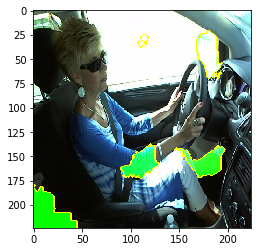

In [0]:
from os import listdir
from os.path import isfile, join
files = [f for f in listdir('/content/drive/My Drive/separated_imgs/val/c0') if isfile(join('/content/drive/My Drive/separated_imgs/val/c0', f))]

for i in files:
  try:
    explain_img('/content/drive/My Drive/separated_imgs/val/c0',i)
  except:
    ValueError

In [0]:
!sudo mv ./*.png /content/drive/My\ Drive/XAI_IMGS_RESULT_MOBILENETV2_ACCURACY=41/